Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import random

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import missingno as msno
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7


In [2]:
#Giving the Directory name for dataset
data_directory = 'D:/Big Data Analytics/Term-2/BDM 3014 - Introduction to Artificial Intelligence 01/Final Project/MangoLeafBD Dataset'
#Giving name to the dataset for EDAs
dataset_name = 'Mango Leaf Disease Dataset'

In [3]:
#Function to get data paths and label
def get_data_paths(data_directory):
    
    #Initializing lists to store data paths and labels
    filepaths = []
    labels = []

    #Getting all the folders from the given directory
    folds = os.listdir(data_directory)

    #Looping through each folder whihch represents labels
    for fold in folds:
        foldpath = os.path.join(data_directory, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


#Calling the function
filepaths, labels = get_data_paths(data_directory)

In [4]:
#function to create one dataframe with both file paths and labels
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    
    return df

df = create_df(filepaths, labels)

In [5]:
#Printing the dataframe to check
df.head()

,filepaths,labels
0,D:/Big Data Analytics/Term-2/BDM 3014 - Introd...,Anthracnose
1,D:/Big Data Analytics/Term-2/BDM 3014 - Introd...,Anthracnose
2,D:/Big Data Analytics/Term-2/BDM 3014 - Introd...,Anthracnose
3,D:/Big Data Analytics/Term-2/BDM 3014 - Introd...,Anthracnose
4,D:/Big Data Analytics/Term-2/BDM 3014 - Introd...,Anthracnose


In [6]:
#Function to check the datasize and classes inside the dataset
def num_from_dataset(df, name='df'):
    print(f"The {name} has {df.shape[0]} images.")
    print(f"The {name} has {len(df['labels'].unique())} classes")
num_from_dataset(df, dataset_name)

The Mango Leaf Disease Dataset has 4000 images.
The Mango Leaf Disease Dataset has 8 classes


In [7]:
#Function to count images inside particular labels
def classes_count(df, name='df'):
    
    print(f"The {name} has: ")

    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"'{name}' has {num_class} images")
        
classes_count(df, dataset_name)

The Mango Leaf Disease Dataset has: 

'Anthracnose' has 500 images
'Bacterial Canker' has 500 images
'Cutting Weevil' has 500 images
'Die Back' has 500 images
'Gall Midge' has 500 images
'Healthy' has 500 images
'Powdery Mildew' has 500 images
'Sooty Mould' has 500 images


Data Cleaning
- Checking for null values
- Handling missing values
- Checking for duplicate values

In [8]:
#Function for data cleaning
def data_cleaning(df, name='df'):
    #Checking for null values
    num_null_vals = sum(df.isnull().sum().values)

    #When there is no null values
    if not num_null_vals:
        print(f"The {name} has no null values")

    #When there i snull values
    else:
        print(f"The {name} has {num_null_vals} null values")
        print('Total null values in each column:\n')
        print(df.isnull().sum())
        
        #Removes rows with null values
        df = df.dropna()
        print(f"\nRows with null values have been removed. The dataset now has {df.shape[0]} rows.")
    
    #Checking for duplicates
    num_duplicates = df.duplicated().sum()

    #When there is no duplication in dataset
    if num_duplicates == 0:
        print(f"\nThe {name} has no duplicate values.")
    
    #When there is duplication in dataset
    else:
        print(f"\nThe {name} has {num_duplicates} duplicate rows.")
        df = df.drop_duplicates()
        print(f"Duplicate rows have been removed. The dataset now has {df.shape[0]} rows.")

    return df

#Assiging new cleaned dataframe to the df
df = data_cleaning(df, dataset_name)


The Mango Leaf Disease Dataset has no null values

The Mango Leaf Disease Dataset has no duplicate values.


EDAs
Class distribution in dataset
- Shows the balance in dataset
- Helps model to be balanced and not biased towards any class

In [9]:
#Function to create graphs with class distribution in dataset
def class_distribution(dataframe, col_name):

    #Making subplots
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Percentage Plot', 'Total Count Plot'),
                        specs=[[{"type": "bar"}, {'type': 'scatter'}]])
    
    #Total counts in dataframe
    total_count = dataframe[col_name].value_counts().sum()
    #Percentage of particular label in dataframe
    percentage_values = (dataframe[col_name].value_counts().values / total_count) * 100

    #Creating bar plot
    fig.add_trace(go.Bar(y=percentage_values.tolist(),
                        x=[str(i) for i in dataframe[col_name].value_counts().index],
                        #Showing the values in percentage 
                        text=[f'{val:.2f}%' for val in percentage_values], 
                        textfont=dict(size=10),
                        name=col_name,
                        textposition='auto',
                        showlegend=False,
                        marker=dict(color=colors)),
                                )
    
    #Creating scatter plot
    fig.add_trace(go.Scatter(x=dataframe[col_name].value_counts().keys(),
                         y=dataframe[col_name].value_counts().values,
                         mode='markers',
                         text=dataframe[col_name].value_counts().keys(),
                         textfont=dict(size=10),
                         marker=dict(size=15, color=colors),
                         name=col_name),
              row=1, col=2)

    #Updating plot
    fig.update_layout(title={'text': 'Disease Distribution in Dataset',
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)
    

#Styling the plot with custom colours
colors = [
    '#3A506B', 
    '#8E8D8A',  
    '#D9BF77',  
    '#6A8D73',  
    '#B84A4A',  
    '#86B3D1',  
    '#B0C4B1',  
    '#9A5A6E',  
    '#C8A165',  
    '#7C6C8E'   
]

#Calling the function
class_distribution(df,'labels')

C:\Users\sudee\AppData\Local\Temp\ipykernel_10796\4089772672.py:16: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



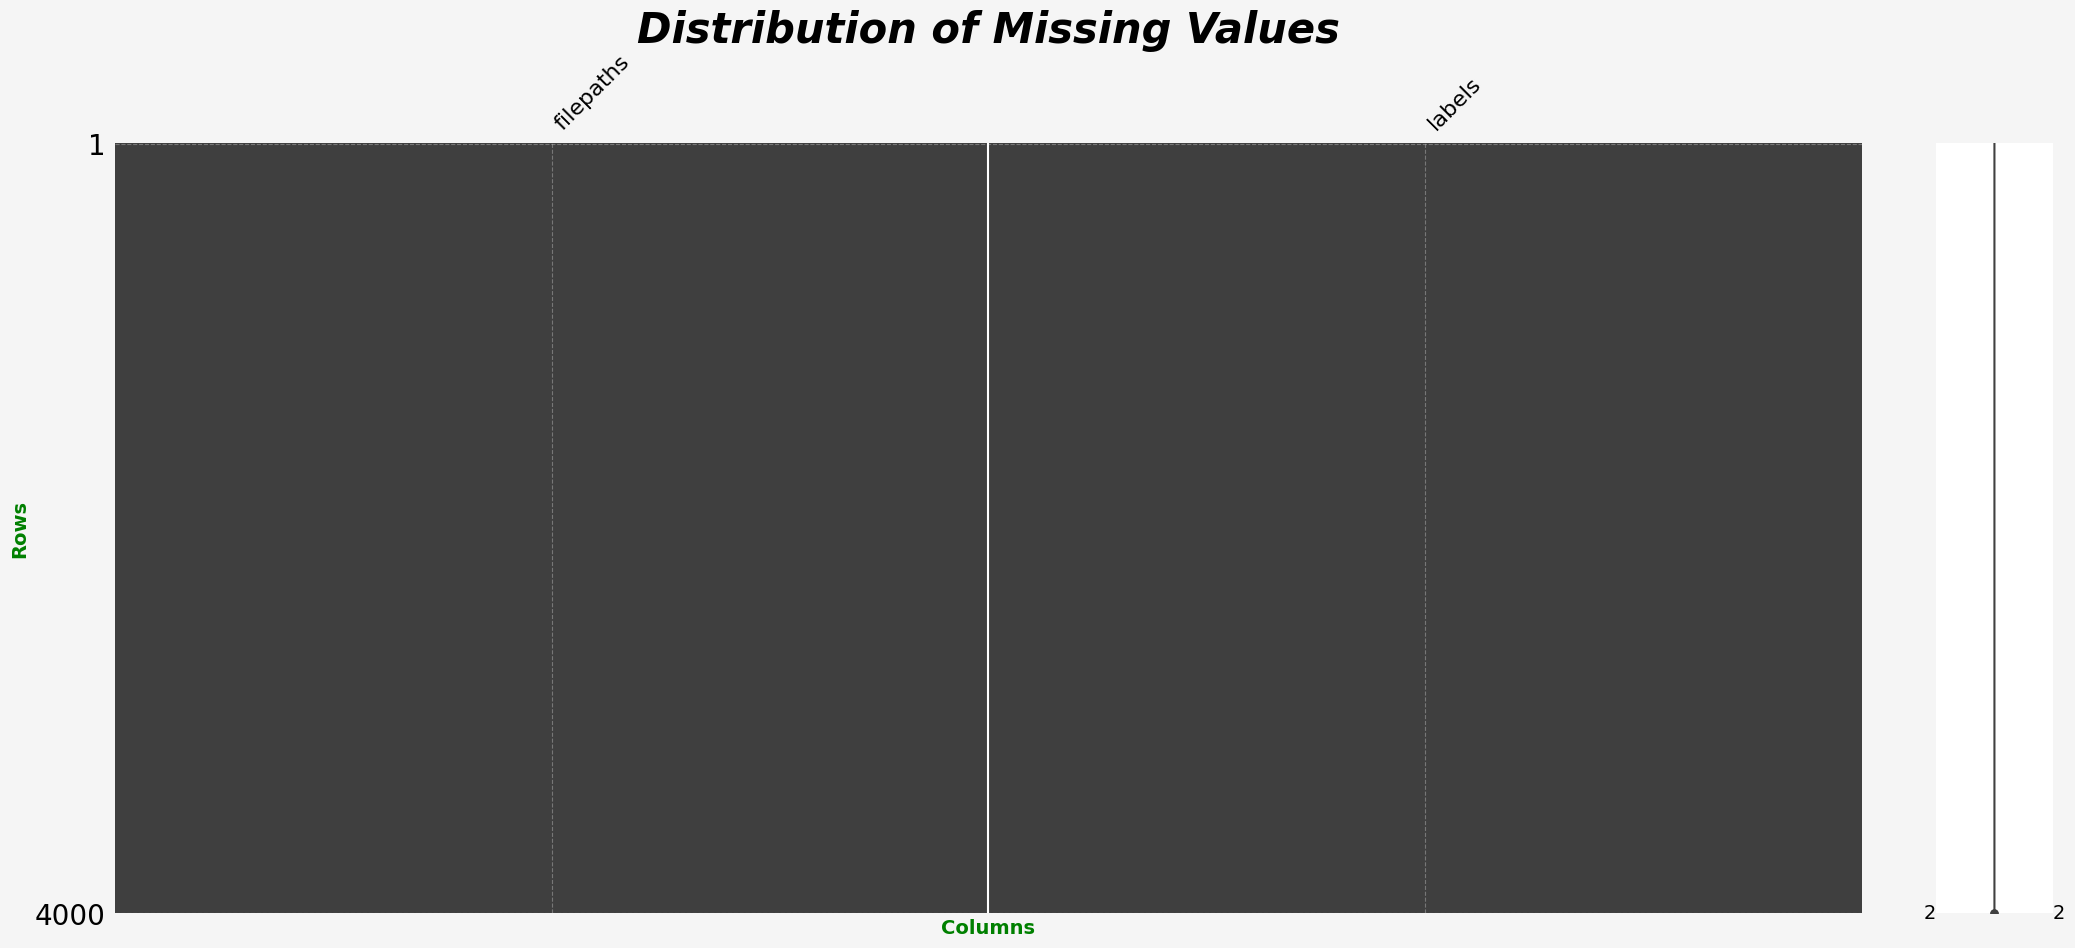

In [10]:

#Ploting the missing values matrix
msno.matrix(df)

#Setting Title and styles
plt.title('Distribution of Missing Values', fontsize=30, fontstyle='oblique', fontweight='bold')

#Custom fonts and colours
plt.xlabel('Columns', fontsize=14, fontweight='bold', color='green')
plt.ylabel('Rows', fontsize=14, fontweight='bold', color='green')

#Custom Background for the plot
plt.gcf().set_facecolor('whitesmoke')
plt.grid(True, linestyle='--', alpha=0.5)

#Adjusting of spacing layout
plt.tight_layout()

#Showing the plot
plt.show()

Pixel Intensity Distribution
- helps to understand the image better and see the features and patterns on the image
- helps to identify textures patterns
- help to differential objects in image

Selected Image: D:/Big Data Analytics/Term-2/BDM 3014 - Introduction to Artificial Intelligence 01/Final Project/MangoLeafBD Dataset\Sooty Mould\IMG_20211108_122752 (Custom).jpg, Label: Sooty Mould


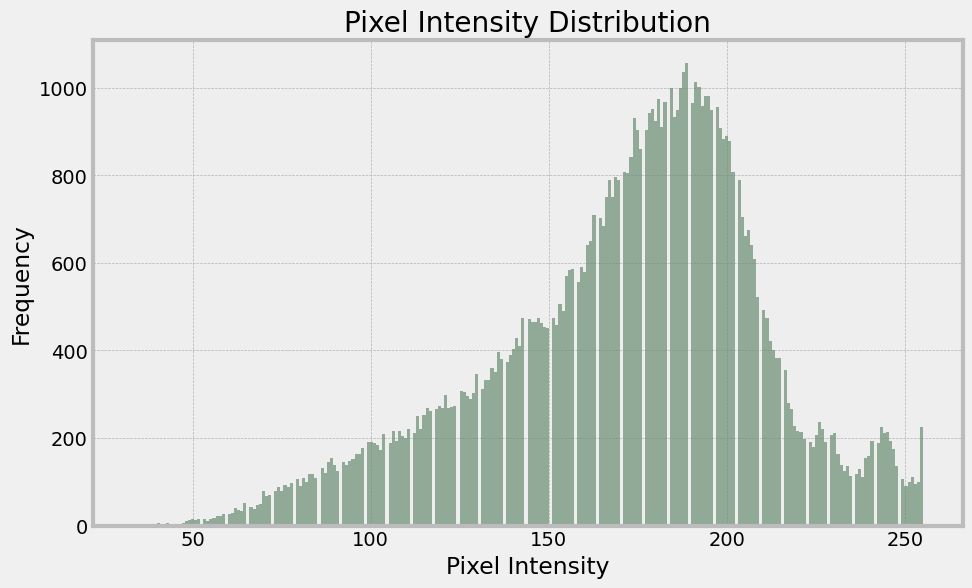

Image Statistics - Mean: 171.3235546875, Std: 38.474207572108575, Min: 33, Max: 255


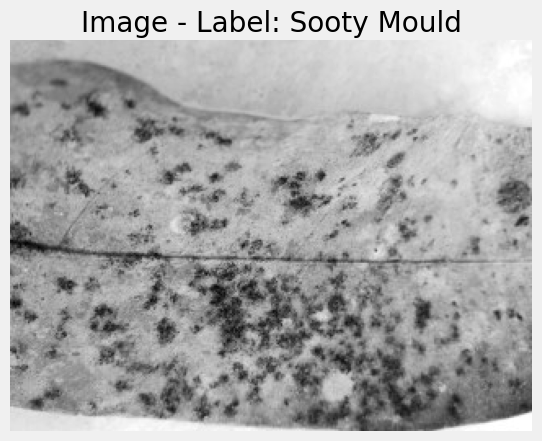

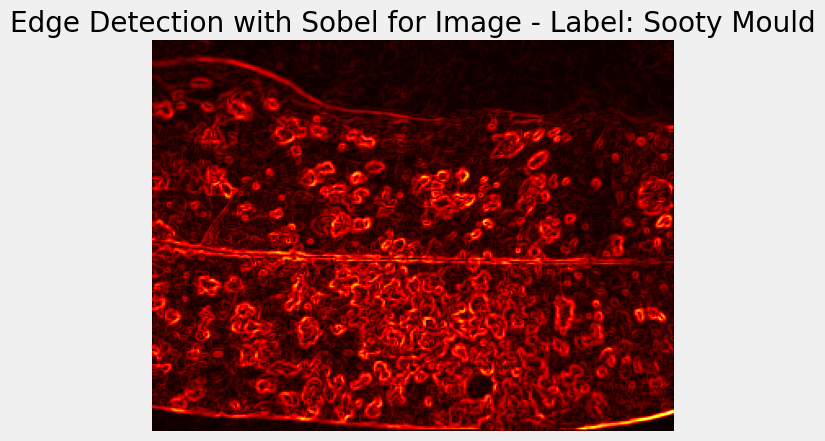

In [ ]:
#Checking one image's pixel intensity and edge detection to see if its good

#Picking a random image from the DataFrame
ran_index = random.choice(df.index)
ran_filepath = df.loc[ran_index, 'filepaths']
ran_label = df.loc[ran_index, 'labels']

#Loading the selected image in grayscale
img = cv2.imread(ran_filepath, cv2.IMREAD_GRAYSCALE)

#Checking if the image was loaded properly
if img is not None:
    print(f"Selected Image: {ran_filepath}, Label: {ran_label}")
    
    #Pixel Intensity Distribution (Histogram) plot
    plt.figure(figsize=(10, 6))

    #Flatting the image array
    plt.hist(img.ravel(), bins=256, color='#6A8D73', alpha=0.7) 
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

    #Basic Statistics of Pixel Intensities
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    min_intensity = np.min(img)
    max_intensity = np.max(img)
    print(f"Image Statistics - Mean: {mean_intensity}, Standard Deviation: {std_intensity}, Min: {min_intensity}, Max: {max_intensity}")
    
    #Displaying the  Grey scale Image
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f"Image - Label: {ran_label}")
    plt.axis('off')
    plt.show()

    #Edge Detection Using Sobel Filter from opencv
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(sobel_x, sobel_y)

    #Visualizing the Edge Detected Image
    plt.figure(figsize=(6, 6))
    plt.imshow(magnitude, cmap='hot')
    plt.title(f"Edge Detection with Sobel for Image - Label: {ran_label}")
    plt.axis('off')
    plt.show()

else:
    print("Error loading the image!")


Train, Test, Validation Split

In [12]:
#Splitting data into training testing and validation
#Training dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

#validation and test dataframe
validation_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [13]:
#Function to check for size of datasets
def data_size(df, name='df'):
    print(f"Number of {name} is {len(df)} images")

In [14]:
#Training dataset size
data_size(train_df, 'Training '+dataset_name)

#Validation dataset size
data_size(validation_df, 'Validation '+dataset_name)

#Testing dataset size
data_size(test_df, 'Testing '+dataset_name)

Number of Training Mango Leaf Disease Dataset is 2800 images
Number of Validation Mango Leaf Disease Dataset is 600 images
Number of Testing Mango Leaf Disease Dataset is 600 images


Feature Engineering
- Image Normalization and Scaling
- Image Augmentation (Rotations, Brightness, Flips)
- Handling Input Sizes and Channels
- Batch Processing 

In [ ]:

#Defining image and batch size parameters

#Number of images to be processed in a batch
batch_size = 40  
#Cropping image size (width, height) in pixels
img_size = (224, 224)
#Number of color channels (RGB)
channels = 3

#Shape of the input image
img_shape = (img_size[0], img_size[1], channels)

#Calculating custom test batch size based on test dataset length
ts_length = len(test_df) 

#Finding the optimal test batch size where number of steps is <= 80
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

#Calculating the number of steps per epoch for the test dataset
test_steps = ts_length // test_batch_size

#Custom scalar function to be used in the ImageDataGenerator; it returns the image without any changes
def scalar(img):
    return img

#Creating an ImageDataGenerator for training with data augmentation (rotation, shifting, zooming, flipping, etc.)
training_gen = ImageDataGenerator(preprocessing_function=scalar,  # Apply the scalar function to the images
                            #Data augmentation parameters
                            rotation_range=40,  
                            width_shift_range=0.2,  
                            height_shift_range=0.2,  
                            brightness_range=[0.4, 0.6],  
                            zoom_range=0.3, 
                            horizontal_flip=True, 
                            vertical_flip=True) 

#Creating a similar ImageDataGenerator for testing (no data augmentation, just scalar function)
#Appling the scalar function to the images
testing_gen = ImageDataGenerator(preprocessing_function=scalar,  
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            brightness_range=[0.4, 0.6],
                            zoom_range=0.3,
                            horizontal_flip=True,
                            vertical_flip=True)

#Generating training data from a DataFrame
train_gen = training_gen.flow_from_dataframe(train_df,  #DataFrame with training data paths and labels
                                       #Column name for image file paths
                                       x_col='filepaths', 
                                       #Column name for image labels 
                                       y_col='labels',
                                       #Resize images to target size (224x224)  
                                       target_size=img_size,  
                                       #Class mode for categorical labels (multi-class classification)
                                       class_mode='categorical',
                                       #Load images as RGB (3 channels)  
                                       color_mode='rgb',
                                       #Shuffle the data for better training  
                                       shuffle=True,  
                                       #Number of images per batch
                                       batch_size=batch_size)  

#Generating validation data from a DataFrame
validation_gen = testing_gen.flow_from_dataframe(validation_df,  #DataFrame with validation data paths and labels
                                            x_col='filepaths',
                                            y_col='labels',
                                            target_size=img_size,
                                            class_mode='categorical',
                                            color_mode='rgb',
                                            shuffle=True,  #Shuffle validation data
                                            batch_size=batch_size)

#Generating test data from a DataFrame
#Using custom test_batch_size and no shuffling since the test data needs to be evaluated as it is
#DataFrame with test data paths and labels
test_gen = testing_gen.flow_from_dataframe(test_df,
                                      x_col='filepaths',
                                      y_col='labels',
                                      target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb',
                                      #Do not shuffle test data
                                      shuffle=False,  
                                      #Custom test batch size calculated earlier
                                      batch_size=test_batch_size) 


Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


Checking batch sample from training data

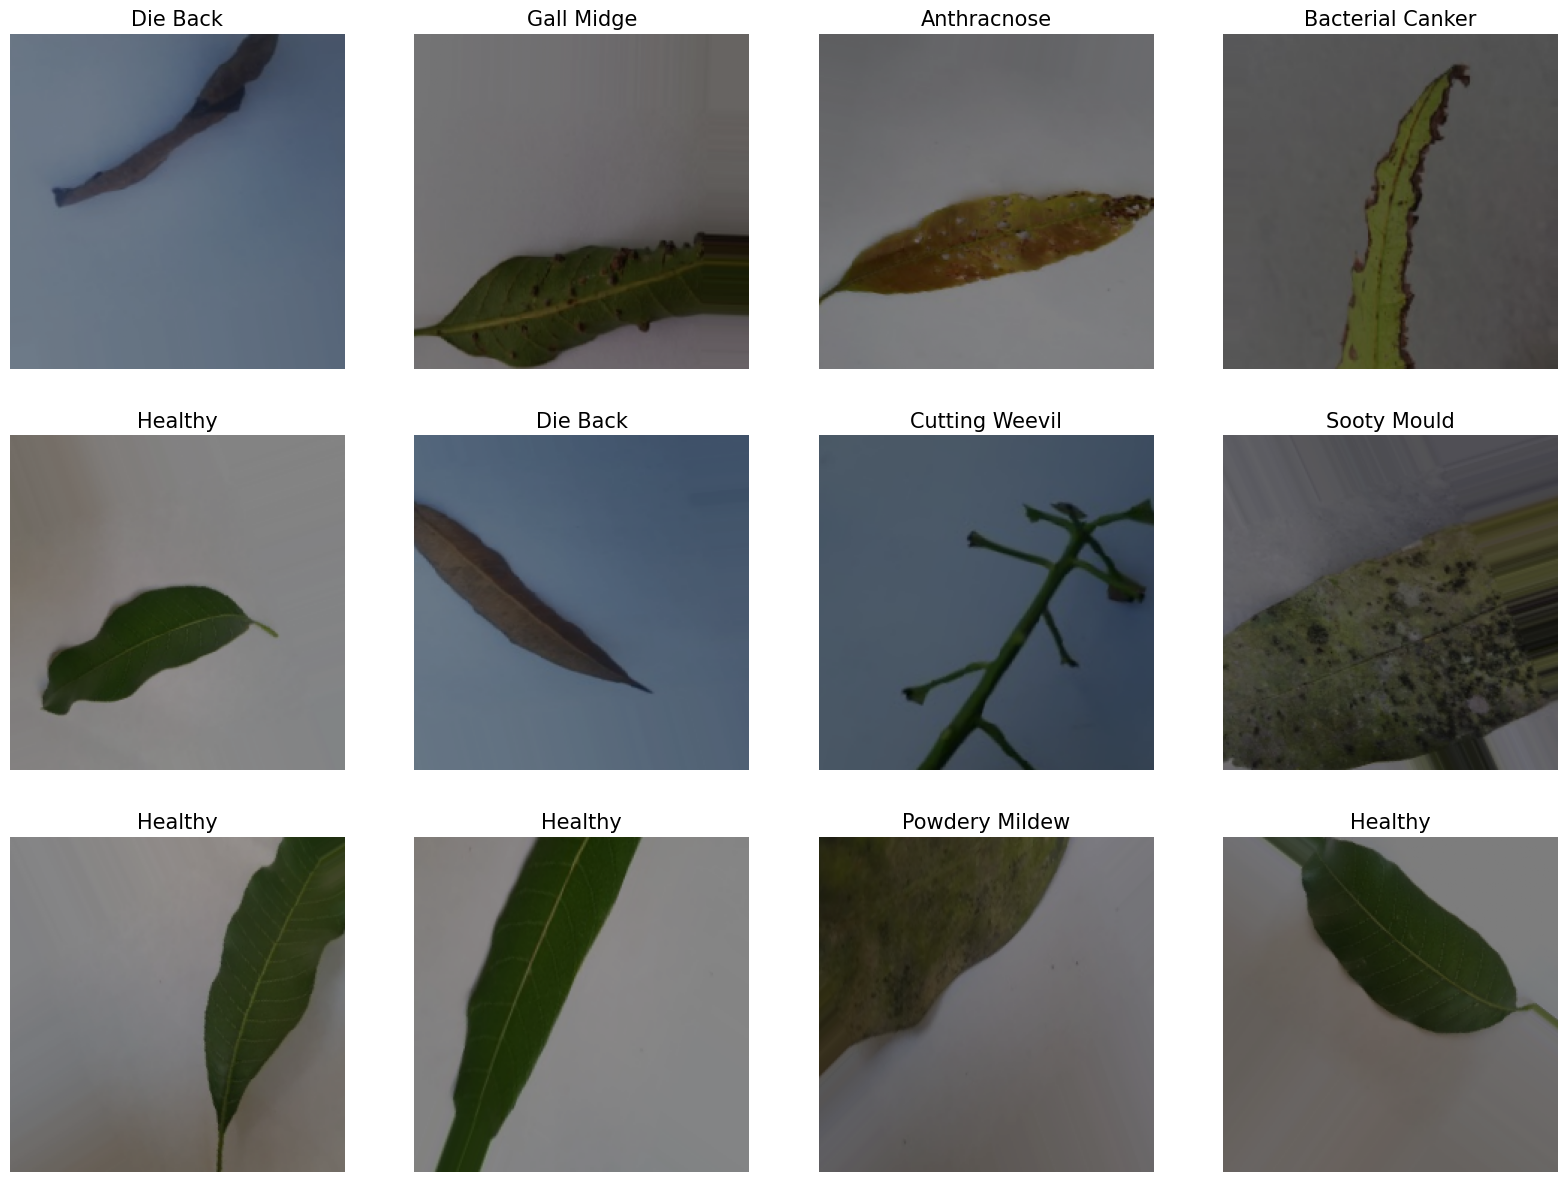

In [16]:
#defines dictionary {'class': index}
gen_dict = train_gen.class_indices   

#defines list of dictionary's kays (classes), classes names : string
classes = list(gen_dict.keys())

#get a batch size samples from the generator
images, labels = next(train_gen)      

plt.figure(figsize= (20, 20))

for i in range(12):
    plt.subplot(4, 4, i + 1)
    #scaling data to range (0 - 255)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index] 
    plt.title(class_name, color= 'black', fontsize= 15)
    plt.axis('off')
    
plt.show()

Squential Model Building

In [17]:
#Creating Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

#to define number of classes in dense layer
class_count = len(list(train_gen.class_indices.keys())) 


#using efficientnetb7 from EfficientNet family.

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

#Building a Sequential model with the EfficientNetB7 base
model = Sequential([
    #Adding the base model
    base_model,  

    #Normalizing inputs for faster training and convergence
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001), 
    #Adding a fully connected layer with 128 units 
    Dense(128,  
          #Adding L2 regularization to the weights
          kernel_regularizer=regularizers.l2(0.016), 
          #Adding L1 regularization to the activations 
          activity_regularizer=regularizers.l1(0.006), 
          #Adding L1 regularization to the biases 
          bias_regularizer=regularizers.l1(0.006),  
          #Using ReLU activation function
          activation='relu'), 
    #Dropout layer to prevent overfitting with a dropout rate of 45% 
    Dropout(rate=0.45, seed=123), 

    #Output layer with softmax activation for multi-class classification 
    Dense(class_count, activation='softmax')  
])

#Compiling the model
#Adamax is an adaptive learning rate optimizer based on Adam
#categorical_crossentropy is used as the loss function for multi-class classification
#Using Adamax optimizer with learning rate 0.001
model.compile(optimizer=Adamax(learning_rate=0.001),  
               #Loss function for categorical classification
              loss='categorical_crossentropy', 
              #Metric to monitor during training is accuracy
              metrics=['accuracy'])  

#Displaying the model architecture summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,436,767 (245.81 MB)

 Trainable params: 333,960 (1.27 MB)

 Non-trainable params: 64,102,807 (244.53 MB)

Putting Early Stop for training the data

In [19]:
#Setting up EarlyStopping callback
early_stopping = EarlyStopping(
    #Monitors the validation loss during training
    monitor='val_loss', 
    #If validation loss doesn't improve for 3 consecutive epochs, training stops early
    #Change is accordingly to the number of epochs you want to wait before stopping
    patience=3,  
    #Restores the model's best weights (with the lowest validation loss) after stopping
    restore_best_weights=True,
    #Looks for the minimum value of 'val_loss' (we want to minimize the loss)
    mode='min'  
)

Data Training with epochs 10 for initial training

In [20]:
#Setting Bacth size fir training
batch_size = 16 

#Setting number of epochs for training
epochs = 10  

history = model.fit(x=train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = validation_gen, 
                    validation_steps = None,
                    shuffle = False,
                    batch_size = batch_size,
                    callbacks = [early_stopping])

c:\Users\sudee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 684s 9s/step - accuracy: 0.4070 - loss: 16.6575 - val_accuracy: 0.6400 - val_loss: 7.7992
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 588s 8s/step - accuracy: 0.4782 - loss: 7.3351 - val_accuracy: 0.5133 - val_loss: 5.4158
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 589s 8s/step - accuracy: 0.3621 - loss: 5.4217 - val_accuracy: 0.2833 - val_loss: 5.0474
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 590s 8s/step - accuracy: 0.3282 - loss: 5.0164 - val_accuracy: 0.3633 - val_loss: 4.7809
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 590s 8s/step - accuracy: 0.3249 - loss: 4.7291 - val_accuracy: 0.4117 - val_loss: 4.5193
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 592s 8s/step - accuracy: 0.3159 - loss: 4.4830 - val_accuracy: 0.3550 - val_loss: 4.2825
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 592s 8s/step - accuracy: 0.3104 - loss: 4.2350 - val_accuracy: 0.3933 - val_loss: 4.0351
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 591s 8s/step - accuracy: 0.3179 - loss: 4.0070 - val_accuracy: 0.4267 - 

Model Evaluation plots
- Training and Validation Loss
- Training and Validation Accuracy

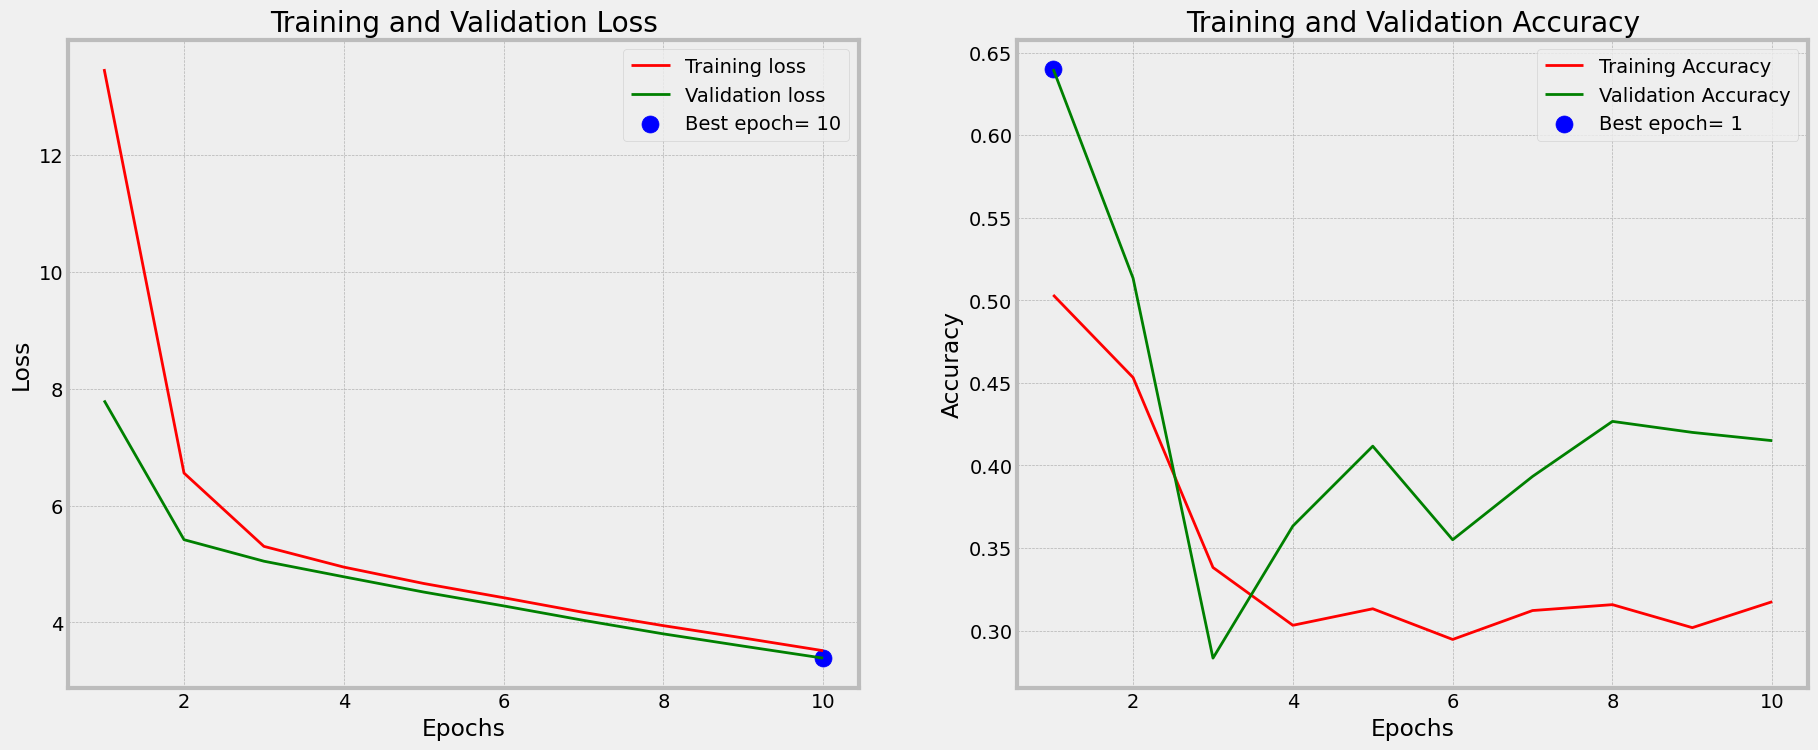

In [ ]:
# Define needed variables
training_acc = history.history['accuracy']
training_loss = history.history['loss']
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']
index_loss = np.argmin(validation_loss)
validation_lowest = validation_loss[index_loss]
index_acc = np.argmax(validation_acc)
acc_highest = validation_acc[index_acc]
Epochs = [i+1 for i in range(len(training_acc))]
loss_label = f'Best epoch= {str(index_loss + 1)}'
acc_label = f'Best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('bmh')

plt.subplot(1, 2, 1)
plt.plot(Epochs, training_loss, 'r', label= 'Training loss')
plt.plot(Epochs, validation_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, validation_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, training_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, validation_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Loss and Accuracy:
- Training
- Validation
- Testing

In [ ]:
test_length = len(test_df)
test_batch_size = max(sorted([test_length // n for n in range(1, test_length + 1) if test_length%n == 0 and test_length/n <= 80]))
test_steps = test_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(validation_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 65s 8s/step - accuracy: 0.4613 - loss: 3.3690
8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 8s/step - accuracy: 0.4191 - loss: 3.3897


c:\Users\sudee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



8/8 ━━━━━━━━━━━━━━━━━━━━ 127s 16s/step - accuracy: 0.4440 - loss: 3.5166
Train Loss:  3.3697636127471924
Train Accuracy:  0.4749999940395355
--------------------
Validation Loss:  3.3829188346862793
Validation Accuracy:  0.421875
--------------------
Test Loss:  3.517380714416504
Test Accuracy:  0.4350000023841858


Prediction for Test

In [26]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 130s 15s/step


Confustion Matrix for Prediction

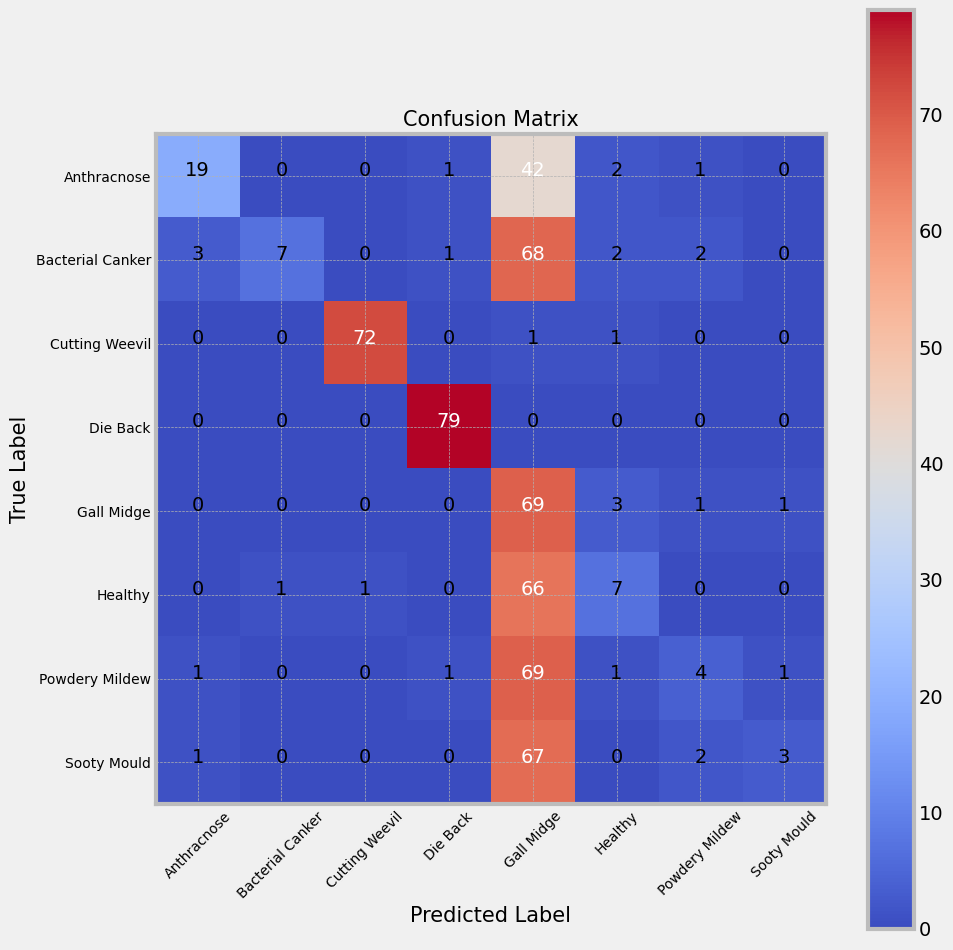

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))

#Picking plot style
plt.style.use('bmh')

#Colour theme
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.coolwarm)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45, fontsize=10)
plt.yticks(tick_marks, classes, fontsize=10)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)

plt.show()

Model Evaluation and Classification Report
- Precision
- Recall
- F1-score
- Support
- Accuracy 
- Macro Average
- Weighted Average

In [ ]:
#Printing classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       0.79      0.29      0.43        65
Bacterial Canker       0.88      0.08      0.15        83
  Cutting Weevil       0.99      0.97      0.98        74
        Die Back       0.96      1.00      0.98        79
      Gall Midge       0.18      0.93      0.30        74
         Healthy       0.44      0.09      0.15        75
  Powdery Mildew       0.40      0.05      0.09        77
     Sooty Mould       0.60      0.04      0.08        73

        accuracy                           0.43       600
       macro avg       0.65      0.43      0.40       600
    weighted avg       0.66      0.43      0.40       600



Saving Model

In [ ]:
#Saving the model
model.save_weights('prediction_model_v1.weights.h5')